<a href="https://colab.research.google.com/github/dasha-shchep/fssh_colab/blob/master/fssh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing the FSSH algorithm on Tully's example problems
This notebook will go through the basic FSSH algorithm and run parallel trajectories as described in the original paper - Tully, J.C. *J. Chem. Phys.* (1990) **93** 1061 - [here](https://doi.org/10.1063/1.459170).

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# !pip install pyscf
# from pyscf import scf

We will limit ourselves at this stage to a two-state model system.
These three types of model potential that Tully described are:

A. Simple avoided crossing (SAX)

B. Dual avoided crossing (DAX)

C. Extended coupling with reflection (ECR)

On the next line we create a SAX potential class:

In [0]:
# Setting up model (1-D potential) classes
# Creating a model class lets us play with more complex model potentials later
class SAXModel:
  """
  First model two-level problem defined by the following interactions in the
  diabatic representstion:
  V11(X) = A[1 - exp(-BX)] for x > 0
  V11(X) = - A[1 - exp(BX)] for x < 0
  V22(X) = - V11(X)
  V21(X) = V12(X) = C exp(-DX**2)
  Default choice of parameters:
  A = 0.01 ; B = 1.6 ; C = 0.005 ; D = 1.0
  """
  _num_states = 2
  _num_dims   = 1
  
  def __init__(self,a=0.01,b=1.6,c=0.005,d=1.0):
    self.A = a
    self.B = b
    self.C = c
    self.D = d

  def V(self,R):
    sign = np.sign(R)
    V11 = sign*self.A*(1 - np.exp(-self.B*sign*R))
    V22 = -V11
    V12 = self.C*np.exp(-self.D*R**2)
    V21 = V12
    return np.array([[V11,V12],[V21,V22]])

  def dV(self,R):
    sign = np.sign(R)
    dV11 = self.A*self.B*np.exp(-self.B*abs(R))
    dV22 = - dV11
    dV12 = self.C*np.exp(-self.D*R**2)
    dV21 = dV12
    return np.array([[dV11,dV12],[dV21,dV22]])

  def diagonalize(self,R):
    self.position = R
    hamiltonian = self.V(R)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian)
    return eigenvalues, eigenvectors

  def NAC(self,R):
    z = (self.V(R)[0,0] - self.V(R)[1,1])/(self.V(R)[0,1]*2e0)
    D12 = - 1/(2*(1+z**2))*((1/(2*self.V(R)[0,1]**2)) * 
          (self.V(R)[0,1]*(self.dV(R)[0,0]-self.dV(R)[1,1])) 
          -self.dV(R)[0,1]*(self.V(R)[0,0]-self.V(R)[1,1]))
    D21 = -D12
    D11 = 0
    D22 = 0
    return np.array([[D11,D12],[D21,D22]])


Nonadiabatic coupling between states 1 and 2 is given by

$d_{12}(R) = \langle\phi_{1}(r;R)|\nabla_{R}\phi_{2}(r;R)\rangle$

where the electronic coordinate $r$ is parametrically dependent on the nuclear coordinate $R$.

In the above class it was analytically derived from eigenvectors of V.

In [9]:
# Instance of SAX class
model = SAXModel()
model._num_states

2

In [6]:
a=0.01;b=1.6;c=0.005;d=1.0;
def coupling(x):
  if (x > 0):
    dcoup = 3
    # dcoup=((4*c*(a*b - (a*b*(-1.0+np.exp(b*x)))/np.exp(b*x)))/
    #   -    (np.exp(d*x**2)*((4*c**2)/np.exp(2*d*x**2) +
    #   -    4*a**2*(1.0 - np.exp(-(b*x)))**2)) +
    #   -    (8*a*c*d*(1.0 - np.exp(-(b*x)))*x)/
    #   -    (np.exp(d*x**2)*((4*c**2)/np.exp(2*d*x**2) +
    #   -    4*a**2*(1.0 - np.exp(-(b*x)))**2)))/2.0
  else:
    dcoup = 4
      # dcoup=((4*a*b*c*np.exp(b*x-d*x**2))/
      # -    ((4*c**2)/np.exp(2*d*x**2)+4*a**2*(1.0-np.exp(b*x))**2)-
      # -    (8*a*c*d*(1.0 - np.exp(b*x))*x)/
      # -    (np.exp(d*x**2)*((4*c**2)/np.exp(2*d*x**2) +
      # -    4*a**2*(1.0-np.exp(b*x))**2)))/2.0
  return dcoup

coupling(-3)

4

Plotting the potentials in the adiabatic representation, with nonadiabatic coupling.

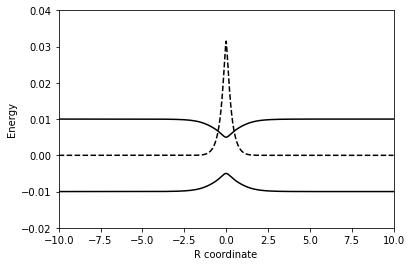

In [21]:
xmin,xmax = -10,10;
x = np.linspace(xmin,xmax,1000);
tens = model.V(x);
eigA = np.zeros(len(x));
eigB = np.zeros(len(x));
for i in range(len(x)):
  eigA[i] = np.linalg.eigh(tens[:,:,i])[0][0]
  eigB[i] = np.linalg.eigh(tens[:,:,i])[0][1]

fig = plt.figure()
# plot diabatic PES
# plt.plot(x, model.V(x)[1,1], 'k-')
# plt.plot(x, model.dV(x)[0,0], 'k-');
# plot adiabatic PES
plt.plot(x, eigA, 'k-');
plt.plot(x, eigB, 'k-');
plt.plot(x, 0.02*model.NAC(x)[1,0], 'k--');
plt.ylim([-0.02,0.04]);
plt.ylabel("Energy");
plt.xlim([-10,10]);
plt.xlabel("R coordinate");

Now that we have the model, can follow step 1:

**Initial conditions for the first trajectory are assigned consistent with the experiment to be simulated. This includes assignment of the initial positions and momenta of all of the atoms, and assignment of the initial electronic density matrix elements $a_{kj}$ Typically, only a single electronic
state $k$ will be populated initially, i.e., $a_{lj} = \delta_{lk} \delta_{jk}$ There is no reason, however, why the initial conditions could not correspond to a coherent or incoherent mixture of electronic
states.**

In [0]:
# Initial momentum
p0 = 10.0
# Initial position
x0 = -6.0
# Initial electronic density matrix: adiabatic population all in state 1 (0 with Python indexing)
a0 = [[1,0],[0,0]]
# Timestep (a.u.)
dt = 0.5
# Mass (a.u.)
mass = 2000.0

Integration of the classical degrees of freedom via the velocity verlet algorithm, as described in step 2.

**The classical mechanical equations of motion for the atoms on the current potential energy surface $V_{kk}$ are integrated for a small time interval $\Delta t$. Equations (8) for the electronic amplitudes or Eq. (11) for the density matrix elements are integrated along this trajectory. The time interval $\Delta t$ may be a single numerical integration time step, or a few steps, so long as it is sufficiently short that the electronic probabilities change only slightly during any interval.**

Eq. (8):

$i\hbar\dot{c}_{k} = \sum_{j} c_{j}\left(V_{kj}-i\hbar \bf{\dot{R}\!\cdot\! d_{kj}}\right)$

Eq. (11):

$i\hbar\dot{a}_{kj} = \sum_{l} \left(a_{lj}\left[V_{kl}-i\hbar \bf{\dot{R}\!\cdot\! d_{kl}}\right]-a_{kl}\left[V_{lj}-i\hbar \bf{\dot{R}\!\cdot\! d_{lj}}\right]\right)$

where
$a_{kj} = c_k^*c_j $.

In [0]:
# Classical propagation of the nuclear DoF with a standard velocity verlet algorithm
def vv(x0ld,p0ld,dt,state,mass):
  v0ld = p0ld/mass
  a0ld = - model.dV(x0ld)[state,state]/mass
  xnew = x0ld + v0ld*dt + 0.5*a0ld*dt*dt
  anew = - model.dV(xnew)[state,state]/mass
  pnew = p0ld + 0.5*(a0ld+anew)*dt*mass
  return xnew, pnew

# Kinetic Energy
def ke(momentum,mass):
  vel = momentum/mass
  return 0.5*vel*vel*mass

# Potential Energy
def pe(position,state):
  return model.V(position)[state,state]

# Total Energy
def te(position,momentum,state,mass):
  return pe(position,state)+ke(momentum,mass)

# Propagation of the density matrix elements a_ij
def dm(c1,c2):
  a11 = c1*np.conj(c1)
  a12 = c1*np.conj(c2)
  a21 = np.conj(a12)
  a22 = c2*np.conj(c2)
  anew = [[a11,a12],[a21,a22]]
  return anew

In [0]:
traj_x = [(-3,5),(-2,1),(4,6),(-4,2),(4,5)];
traj_x[1][1];
time = 0
list = []
state = 0
while time < 300:
  traj_x = [vv(x[0],x[1],dt=10,state=state,mass=mass) for x in traj_x]
  list.append(traj_x)
  time += dt

In [0]:
trajectoryApos = []
trajectoryAmom = []
Kenergy = []
Penergy = []
Tenergy = []
for i in range(600):
  trajectoryApos.append(list[i][3][0])
  trajectoryAmom.append(list[i][3][1])
  Kenergy.append(ke(trajectoryAmom[i],mass=mass))
  Penergy.append(pe(trajectoryApos[i],state=state))
  Tenergy.append(te(trajectoryApos[i],trajectoryAmom[i],state=state,mass=mass))



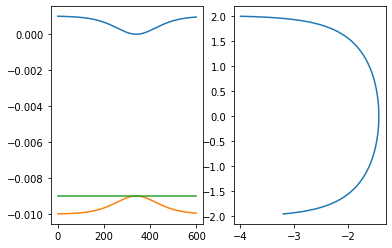

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2);
ax1.plot(Kenergy);
ax1.plot(Penergy);
ax1.plot(Tenergy);
ax2.plot(trajectoryApos,trajectoryAmom);

In [0]:
# initialize electronic state
c1 = 0.9
c2 = np.sqrt(1.-c1*c1)
a11 = c1*np.conj(c1)
a12 = c1*np.conj(c2)
a21 = np.conj(a12)
a22 = c2*np.conj(c2)
a0 = [[a11,a12],[a21,a22]]
a0

[[0.81, 0.39230090491866054], [0.39230090491866054, 0.18999999999999992]]

In [0]:
x0=-0.1
p0=1000
hbar = 1
c1 += dt*(c1*model.V(x0)[0,0]/(1j*hbar) - c2*(p0/mass)*model.NAC(x0)[0,0]);
c2 += dt*(c2*model.V(x0)[0,0]/(1j*hbar) + c1*(p0/mass)*model.NAC(x0)[1,1]);
c1
a = dm(c1,c2)

In [0]:
b12 = -2.*(np.conj(a[0][1])*(p0/mass)*model.NAC(x0)).real
b21 =  2.*(np.conj(a[1][0])*(p0/mass)*model.NAC(x0)).real

In [0]:
dt*b21[1][0]/(a[0][0].real)

0.30617508929203485

Step 3:

**The switching probabilities $g_{kj}$ from the current electronic state $k$ to all other states $j$ are computed from the density matrix elements using Eq. (14) and the expression**

$g_{kj} = \frac{\Delta t b_{jk}}{a_{kk}}$

**If $g_{kj}$ from Eq. (19) is negative, it is set equal to zero. A uniform random number, $\zeta$, $ 0 < \zeta < 1$, is then selected to determine whether a switch to any state $j$ will be invoked. For example, if $k = 1$, a switch to state 2 will occur if $\zeta < g_{12}$. A switch to state 3 will occur if $g_{12} < \zeta < g_{13} + g_{13}$ etc.**

In [0]:
# Calculate hopping probability & random number generator
def surface_hop():
  zeta = np.random.rand()
  test = dt*b21[1][0]/(a[0][0].real)
  if zeta < test:
    bool = True
  elif zeta > test:
    bool = False
  else:
    print("Error")
  return bool

In [0]:
surface_hop()

True

In [0]:
vect = np.random.rand(1,8)
print(vect)
for i in vect:
  print(model.V(i))


[[0.53031308 0.94950789 0.75185514 0.48055579 0.6764164  0.56763408
  0.61814736 0.70126356]]
[[[ 0.00571944  0.00781116  0.00699698  0.00536472  0.00661173
    0.00596756  0.00628065  0.00674379]
  [ 0.00377427  0.00202967  0.00284099  0.00396896  0.0031642
    0.00362274  0.00341211  0.00305771]]

 [[ 0.00377427  0.00202967  0.00284099  0.00396896  0.0031642
    0.00362274  0.00341211  0.00305771]
  [-0.00571944 -0.00781116 -0.00699698 -0.00536472 -0.00661173
   -0.00596756 -0.00628065 -0.00674379]]]


In [0]:
# Generate initial conditions
numTraj = 100
dT = 1 # timestep
initP = 0
initQ = 1
mass = 2000

In [0]:
# Classical nuclei velocity verlet integrator
acceleration = force / mass
def velocity_verlet(old_position, old_velocity, timestep,acceleration):
  new_position = old_position + old_velocity * timestep
  new_velocity = old_velocity + acceleration * timestep
  return new_position, new_velocity

0.11418160778148789

In [0]:
# Calculate hopping probability & random number generator
def surface_hop():
  random_number = np.random.rand()
  test
  if random_number < test:
    bool = True
  elif random_number > test:
    bool = False
  else:
    print("Error")
  return bool

Trying to run CUDA on Colab GPUs

In [0]:
import torch

In [2]:
torch.cuda.memory_allocated()

0

In [0]:
a = torch.rand(128,600).cuda()

In [0]:
b = np.random.rand(128,600)

In [0]:
def func(obj):
  out = obj**2
  return out

In [19]:
%timeit [func(i) for i in a]

1000 loops, best of 3: 1.75 ms per loop


In [13]:
%timeit func(b)

The slowest run took 6.29 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 84.5 µs per loop


In [0]:
# class DAXModel:
#  def __init__(self):
#    self.representation = representation # Adiabatic or Diabatic

In [0]:
# Initial electronic state (where to start the dynamics)
cstate = 0

# Time step (au)
dt = 0.2

# Time of simulation (au)
t_init  = 0.0
t_final = 1300.0

# Seed for random number generator
seed = 123

# Flag to include decoherence
decoherence = False

In [0]:
import os
import sys
import math
import random
from autograd import grad
import autograd.numpy as np
import warnings
warnings.filterwarnings("ignore")

from scipy.linalg import expm
from scipy.integrate import solve_ivp


In [0]:
# Define number of electronic states
nel = 2
# PES parameters (atomic units)
mass = 2000.0

A = 0.1
B = 0.28
C = 0.015
D = 0.06
E = 0.05

def V11(x):
    return 0.0

def V22(x):
    return -A*(np.exp(-B*(x**2)))+E

V12 = lambda x: C*np.exp(-D*(x**2))

all_diabats = [V11, V22]
all_couplings = [V12]

In [0]:
# Assert length of all diabats is nel
# And length of coupling list is nel*(nel-1)/2
assert len(all_diabats) == nel;
assert len(all_couplings) == (nel*(nel-1))//2

# Get adibatic energies
def get_energies(x):

    '''
    Diagonalize nel x nel PEM at a given geometry to obtain the
    adaiabtic electronic energies (and also eigenvectors).
    '''

    # Initialize
    V_mat = np.zeros((nel, nel))

    # Fill elements
    for a in range(nel):
        for b in range(nel):
            if a == b:
                V_mat[a][a] = all_diabats[a](x)
            elif b > a:
                # Use floor division for pure integers, unlike Python 2. Duh!
                k = (nel*(nel)//2) - (nel-a)*((nel-a))//2 + b - a - 1
                V_mat[a][b] = all_couplings[k](x)
                V_mat[b][a] = V_mat[a][b]

    # Diagonalize
    E_val, E_vec  = np.linalg.eigh(V_mat)

    return E_val, E_vec

In [0]:
# Get gradients 'analytically'
def makegradmatrix(x):

    '''
    dV/dx
    '''

    # Make grad matrix (evaluate at current x)
    grad_matrix = np.zeros((nel, nel), dtype=np.ndarray)

    # Use automatic differentiation to get gradients of individual Vmn
    for a in range(nel):
        for b in range(nel):
            if a == b:
                grad_matrix[a, b] = grad(all_diabats[a])(x)
            elif a != b and a > b:
                k = (nel*(nel)//2) - (nel-a)*((nel-a))//2 + b - a - 1
                grad_matrix[a, b] = grad(all_couplings[k])(x)
                grad_matrix[b, a] = grad_matrix[a, b]
            else:
                pass

    return grad_matrix

In [0]:
def get_gradients_and_nadvec(x):

    '''
    '''
    # Initialize
    analytical_gradients = np.zeros(nel)

    # Diagonalize potential matrix
    val, vec = get_energies(x)

    # Make grad matrix (evaluate at current x)
    grad_matrix = makegradmatrix(x)

    # Get gradient
    for a in range(nel):
        analytical_gradients[a] = np.dot(vec[:,a].T, np.dot(grad_matrix, vec[:,a]))

    # Get nonadiabatic coupling
    nadvec = np.zeros((nel*(nel-1))//2)
    for a in range(nel):
        for b in range(nel):
            if a != b and a > b:
                # print(a, b)
                k = (nel*(nel)//2) - (nel-a)*((nel-a))//2 + b - a - 1
                # Nonadiabtic coupling between state a and b
                numerator = np.dot(vec[:,b].T, np.dot(grad_matrix, vec[:,a]))
                # TODO: Check for degerenacy of state a and state b
                # Give Warning fo HUGE nadvec and quit if tending to infinity.
                # NOTE: How do QM programs deal with it?
                nadvec[k] = numerator/(val[b] - val[a])
            else:
                pass

    return val, analytical_gradients, nadvec

In [0]:
hbar = 1.0

def update_x(x_current, v_current, a_current, dt):

    '''
    x(t + dt) = x(t) + v(t)*dt + 0.5*a(t)*dt**2
    '''
    x_new = x_current + v_current*dt + 0.5*a_current*(dt**2)
    return x_new


def update_v(v_current, a_current, a_new, dt):
    '''
    v(t + dt) = v(t) + 0.5*(a(t) + a(t + dt))*dt
    '''
    v_new = v_current + 0.5*(a_current + a_new)*dt
    return v_new


def func_prop(t, y):
    '''
    Function for ODE solver
    '''
    return np.dot(e_prop_mat, y)

In [0]:
def surface_hopping(c_coeff, x_current, v_current, f_current, E_ad, dt, cstate):
    '''
    Main function for surface hopping dynamics:

    1. Solve TDSE (propagate electronic c)
    2. Compute hopping probability (FSSH, others)
    3. Adjust momentum if a hop has occured
    '''

    # Create density matrix
    amat = np.outer(c_coeff, np.conj(c_coeff))

    # Set HOP to False
    HOP = False

    # Create bmat and gmat
    bmat = np.zeros((nel*(nel-1))//2)
    gmat = np.zeros((nel*(nel-1))//2)

    # Generate random number
    rand_num = random.uniform(0, 1)

    # Compute hopping probabilities (adiabatic) and decide whether to hop or not
    for a in range(nel):
        if a != cstate:
            # print('Compute hopping from state', cstate, 'to state', a)
            k = (nel*(nel)//2) - (nel-a)*((nel-a))//2 + cstate - a - 1
            # Note that NACVEC satisfies: f_ab = - (f_ba)*
            if a > cstate:
                bmat[k] = - 2.*np.real(np.conj(amat[cstate,a])*(np.dot(v_current, f_current[k])))
            else:
                bmat[k] = - 2.*np.real(np.conj(amat[cstate,a])*(np.dot(v_current, -np.conj(f_current[k]))))
                gmat[k] = max(0., (bmat[k]/np.real(amat[cstate, cstate]))*dt)
            # print('k, gmat, rand_num', k, gmat[k], rand_num)
            if gmat[k] > rand_num:
                HOP = True
                # print('Hopping from state', cstate, 'to state', a)
                pstate = cstate
                cstate = a
                break
            else:
                pstate = cstate
                continue
        else:
                pass

    # If a hop has occurred, adjust momentum and check for frustrated hops
    if HOP:
        # Note that hop has occurred from pstate to cstate (new def)
        # Compute quantities aij, bij (from the change in kinetic energy)
        k = (nel*(nel)//2) - (nel-pstate)*((nel-pstate))//2 + cstate - pstate - 1
        if pstate < cstate:
            f_current[k] = - np.conj(f_current[k])
        else:
            pass
        ak = (f_current[k]**2)/(2.*mass)
        bk = f_current[k]*v_current
        resid = bk**2 + 4.*ak*(E_ad[pstate] - E_ad[cstate])

        # Check for real roots
        if resid < 0. :
            print('Frustated hop occurred. Reverse hopping and velocities')
            gamma = bk/ak
            v_new = v_current - gamma*(f_current[k]/mass)
            # Reverse Hopping too!
            HOP = False
            temp = cstate
            cstate = pstate
            pstate = temp
        else:
            print('Adjusting momentum in a regular way after HOP')
            if bk < 0.:
                gamma = (bk + np.sqrt(resid))/(2.*ak)
            else:
                gamma = (bk - np.sqrt(resid))/(2.*ak)
            v_new = v_current - gamma*(f_current[k]/mass)
    else:
        # No HOP has occurred. Exit gracefully!
        v_new = v_current

    return pstate, cstate, v_new, HOP

In [0]:
x_init = -6.0
v_init = 0.0075
t = t_init

In [0]:
x_previous = x_init
v_previous = v_init

E_previous, G_previous, F_previous = get_gradients_and_nadvec(x_previous)
a_previous = -G_previous[cstate]/mass

ci_previous = np.zeros(nel, dtype='complex64')
ci_previous[cstate] = 1.0

count = 0

In [0]:
while(t < t_final):
        # Solve Nuclear Dynamics
        x_current = update_x(x_previous, v_previous, a_previous, dt)
        E_current, G_current, F_current = get_gradients_and_nadvec(x_current)
        a_current = -G_current[cstate]/mass
        v_current = update_v(v_previous, a_previous, a_current, dt)

        # TDSE Propagator Matrix
        e_prop_mat = np.zeros((nel, nel), dtype='complex64')
        diag_elements = -1j*(E_current - E_current[0])/hbar
        np.fill_diagonal(e_prop_mat, diag_elements)
        for a in range(nel):
            for b in range(nel):
                if a != b and a > b:
                    k = (nel*(nel)//2) - (nel-a)*((nel-a))//2 + b - a - 1
                    e_prop_mat[a,b] = - np.dot(v_current, F_current[k])
                    e_prop_mat[b,a] = - np.dot(v_current, - np.conj(F_current[k]))
                else:
                    pass

        # Solve ODE. Ugh!
        ci_current = solve_ivp(func_prop, (t, t+dt), ci_previous)['y'][:,1]

        # Norm (or total population, should sum to 1.0)
        total_population = 0.0
        for i in range(nel):
            total_population += abs(ci_current[i])**2
        
        E_kin = 0.5*mass*(v_current**2)
        E_pot = E_current[cstate]
        E_tot = E_kin + E_pot

        # Call hopping subroutine: calculate hopping probability and adjust momentum
        pstate, cstate, v_current, hop_status = surface_hopping(ci_current, x_current, v_current, F_current, E_current, dt, cstate)

        # Set current to previous
        x_previous = x_current
        v_previous = v_current
        a_previous = a_current
        ci_previous = np.copy(ci_current)

        # Update time
        t = t + dt

        # Update time counter
        count += 1